In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.features import geometry_mask
import rioxarray
import scipy
from shapely.geometry import shape, Polygon
import xrspatial

from valleys.utils import setup_wbt
from valleys.utils import get_stream_raster_from_hillslope
from valleys.utils import vectorize_stream
from valleys.cross_section import preprocess_channel
from valleys.cross_section import get_cross_section_points
from valleys.terrain import get_terrain_features
from valleys.breakpoints import get_break_points
from valleys.breakpoints import map_valley_floor

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
wbt = setup_wbt(os.path.expanduser("~/opt/WBT/"), os.path.abspath("../data/wb_outputs/"))

## Load in test valley

In [25]:
# 1801, 12
# 1807, 4
# 1804, 22

#dem = rioxarray.open_rasterio(os.path.abspath("../data/huc12s/180101100904/subbasins/12.0_dem.tif")).squeeze()
#dem = rioxarray.open_rasterio(os.path.abspath("../data/huc12s/180701020604/subbasins/4.0_dem.tif")).squeeze()
dem = rioxarray.open_rasterio(os.path.abspath("../data/huc12s/180400060403/subbasins/22.0_dem.tif")).squeeze()

#hs = rioxarray.open_rasterio(os.path.abspath("../data/huc12s/180101100904/subbasins/12.0_hillslopes.tif")).squeeze()
#hs = rioxarray.open_rasterio(os.path.abspath("../data/huc12s/180701020604/subbasins/4.0_hillslopes.tif")).squeeze()
hs = rioxarray.open_rasterio(os.path.abspath("../data/huc12s/180400060403/subbasins/22.0_hillslopes.tif")).squeeze() 

## Get Break Points

In [28]:
stream_binary = get_stream_raster_from_hillslope(wbt, hs)
stream = vectorize_stream(wbt, stream_binary)
centerline = preprocess_channel(stream, method='simplify', threshold=15).iloc[0]
points = get_cross_section_points(centerline, xs_spacing=20, xs_width=400, xs_point_spacing=10)
points, slope, curvature, hand = get_terrain_features(wbt, points, dem, hs)
break_points = get_break_points(points, peak_threshold=0.003, slope_threshold=0.25)
break_points = break_points.loc[break_points['hand'] < 100]

## Viz

In [29]:
hillshade = xrspatial.hillshade(dem)

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:23: RuntimeWarning: invalid value encountered in sin
  shaded = np.sin(altituderad) * np.sin(slope) + \
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:24: RuntimeWarning: invalid value encountered in cos
  np.cos(altituderad) * np.cos(slope) * \
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:25: RuntimeWarning: invalid value encountered in cos
  np.cos((azimuthrad - np.pi/2.) - aspect)


/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

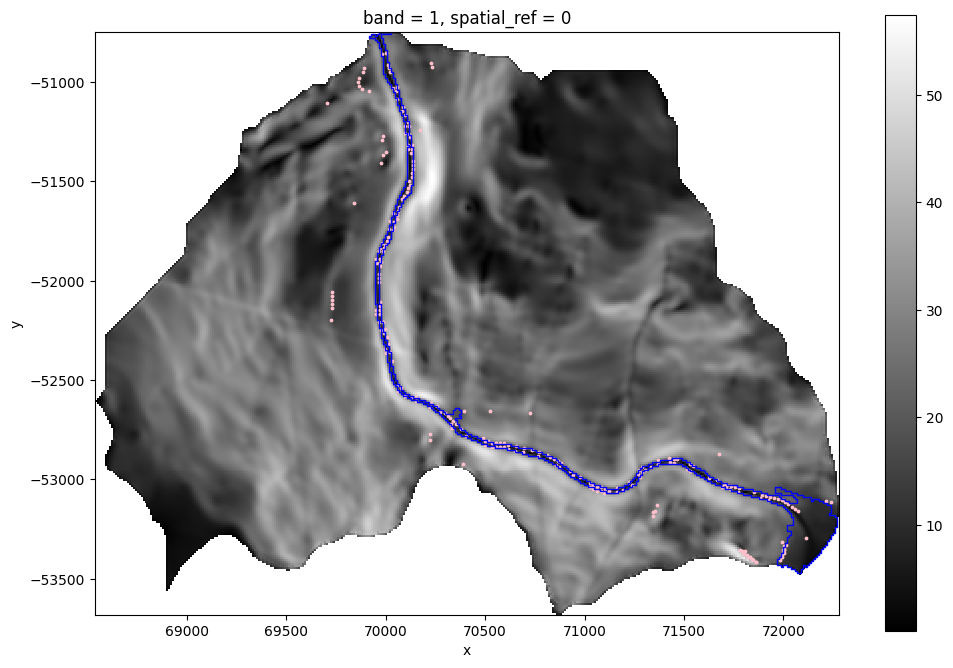

In [33]:
vf = map_valley_floor(break_points, hand, slope, quantile=0.8, buffer=0, slope_threshold=20)
vf = vf.loc[vf.area > 10000]

fig, ax = plt.subplots(figsize=(12,8))
slope.plot(ax=ax, cmap='gray')
break_points.plot(ax=ax, color='pink', markersize=3)
vf.dissolve().plot(ax=ax, facecolor='none', edgecolor='blue')